# VAE experiments

* [Downloading dataset](#download)
* [Fully-connected VAE](#fc-vae)
* [Gumbel-softmax categorical VAE](#gumbel-vae)
* [CNN VAE](#cnn-vae)
* [LSTM VAE](#lstm-vae)
* [Adversarial VAE](#aae)
* [QRNN VAE](#qrnn-vae)


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

Found GPU at: /device:GPU:0
TensorFlow Version: 1.14.0-rc1


<a id='download'></a>

## Downloading dataset

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import (
    Input, Dense, Lambda, Flatten, Reshape, Dropout, LSTM, RepeatVector,
    Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Conv1D, concatenate)
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras import objectives
from keras import activations
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
def show_images(images):
    import matplotlib.gridspec as gridspec
    
    sqrtn = int(np.ceil(np.sqrt(len(images))))
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img[:,:,0], cmap='gray')
    plt.show()
    

class dataset_batches():
    def __init__(self, x_train, shuffle=True):
        self.shuffle = shuffle
        self.x_train = self.scale(x_train)
        
    def batches(self, batch_size):
        n = len(self.x_train)
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            self.x_train = self.x_train[idx]
            
        n_batches = n // batch_size
        for i in range(0, n, batch_size):
            yield self.x_train[i:i+batch_size]

    def scale(self, x_train):
        return x_train * 2 - 1

In [0]:
def load_mnist_data(dim):
    from keras.datasets import mnist
    from keras.utils import to_categorical
    num_classes = 10
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    print(len(X_train), 'train samples')
    print(len(X_test), 'test samples')
    
    if dim == 3:
        if K.image_data_format() == 'channels_first':
            X_train = X_train.reshape(len(X_train), 1, 28, 28)
            X_test = X_test.reshape(len(X_test), 1, 28, 28)
        else:
            X_train = X_train.reshape(len(X_train), 28, 28, 1)
            X_test = X_test.reshape(len(X_test), 28, 28, 1)
    elif dim == 1:
        X_train = X_train.reshape(len(X_train), -1)
        X_test = X_test.reshape(len(X_test), -1)

    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_mnist_data(dim=1)

60000 train samples
10000 test samples
X_train shape: (60000, 784)
X_test shape: (10000, 784)


<a id='fc-vae'></a>

## Fully connected VAE

In [0]:
class fc_vae():
    def __init__(self, original_dim):
        self.original_dim = original_dim
        self.img_shape = (original_dim, )
        self.latent_dim = 2

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        z_mean, z_log_var, encoded_repr = self.encoder(img)
        img_reconst = self.decoder(encoded_repr)

        self.vae = Model(img, img_reconst)
        
        def vae_loss(inputs, outputs):
            # VAE loss = mse_loss or xent_loss + kl_loss
            if True:
                reconst_loss = self.original_dim * objectives.mse(inputs, outputs)
            else:
                reconst_loss = self.original_dim * objectives.binary_crossentropy(inputs, outputs)
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(reconst_loss + kl_loss)
        
        self.vae.compile(optimizer='adam', loss=vae_loss)


    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling from an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            latent_dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
        # Encoder
        inputs = Input(shape=self.img_shape)
        x = Dense(512, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        latent_repr = Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        encoder = Model(inputs, [z_mean, z_log_var, latent_repr])
        print(encoder.summary())
        return encoder

    
    def build_decoder(self):
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim, ))
        x = Dense(512, activation='relu')(latent_inputs)
        outputs = Dense(self.original_dim, activation='sigmoid')(x)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder


    def train(self, X_train, X_test, epochs, batch_size):
        file_path = 'weights.h5'
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                                     save_best_only=True, mode='min')
        early = EarlyStopping(monitor='val_loss', mode='min', patience=5)

        self.vae.fit(X_train, X_train,
                     shuffle=True,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_test, X_test),
                     callbacks=[checkpoint, early])

In [0]:
original_dim = 784
epochs = 20
batch_size = 128

vae = fc_vae(original_dim)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [0]:
vae.train(X_train, X_test, epochs=epochs, batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 73us/step - loss: 51.7698 - val_loss: 43.9172

Epoch 00001: val_loss improved from inf to 43.91715, saving model to weights.h5
Epoch 2/20
60000/60000 [==============================] - 4s 64us/step - loss: 43.2075 - val_loss: 42.3829

Epoch 00002: val_loss improved from 43.91715 to 42.38287, saving model to weights.h5
Epoch 3/20
60000/60000 [==============================] - 4s 65us/step - loss: 42.1920 - val_loss: 41.5924

Epoch 00003: val_loss improved from 42.38287 to 41.59238, saving model to weights.h5
Epoch 4/20
60000/60000 [==============================] - 4s 65us/step - loss: 41.4881 - val_loss: 41.0580

Epoch 00004: val_loss improved from 41.59238 to 41.05800, saving model to weights.h5
Epoch 5/20
60000/60000 [==============================] - 4s 64us/step - loss: 40.9783 - val_loss: 40.6658

Epoch 00005: val_loss improved from 41.05800 to 40.66578, saving model to w

In [0]:
vae.vae.save_weights('vae1.h5')

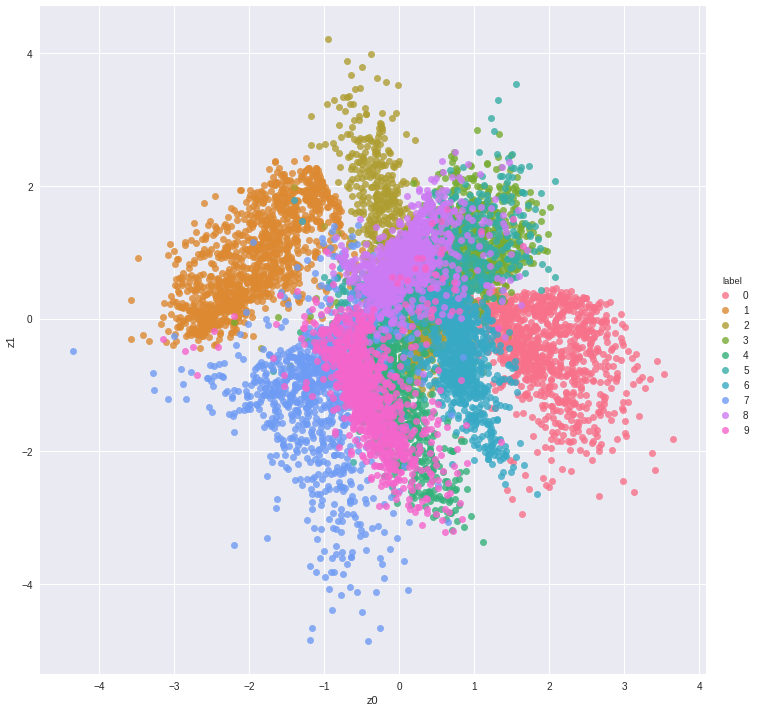

In [0]:
# Predict on test set
z_mean, _, _ = vae.encoder.predict(X_test)

data = pd.DataFrame(z_mean)
data.columns = ['z0', 'z1']
data['label'] = y_test
sns.lmplot(x="z0", y="z1", hue="label", data=data, fit_reg=False, size=10)

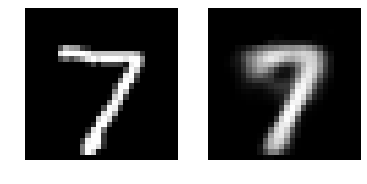

In [0]:
img = X_test[0].reshape(1, 784)
_, _, z_sample = vae.encoder.predict(img)
x_decoded = vae.decoder.predict(z_sample)

plt.figure()
plt.subplot(121)
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(x_decoded.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

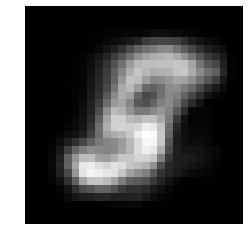

In [0]:
z_sample = np.array([[0, 0.1]])
x_decoded = vae.decoder.predict(z_sample)

plt.figure()
plt.imshow(x_decoded.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

<a id='gumbel-vae'></a>

## Gumbel-softmax categorical VAE

In [0]:
class gumbel_softmax_vae():
    def __init__(self, original_dim, M, N, tau, anneal_rate, min_temperature):
        self.original_dim = original_dim
        self.img_shape = (original_dim, )
        self.M = M  # number of classes
        self.N = N  # number of categorical distributions
        self.tau = tau
        self.anneal_rate = anneal_rate
        self.min_temperature = min_temperature
        self.eps = 1e-20
        
        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr, logits_y = self.encoder(img)
        img_reconst = self.decoder(encoded_repr)

        self.vae = Model(img, img_reconst)
        
        def gumbel_loss(inputs, outputs):
            reconst_loss = self.original_dim * objectives.binary_crossentropy(inputs, outputs)
            q_y = K.reshape(logits_y, (-1, self.N, self.M))
            q_y = activations.softmax(q_y)
            log_q_y = K.log(q_y + self.eps)
            kl_loss = -K.sum(q_y * (log_q_y - K.log(1.0/self.M)), axis=(1, 2))
            elbo = reconst_loss + kl_loss
            return K.mean(elbo)
        
        self.vae.compile(optimizer=Adam(0.0002, 0.5), loss=gumbel_loss)


    def build_encoder(self):
        def sampling(logits_y):
            U = K.random_uniform(K.shape(logits_y), 0, 1)
            y = logits_y - K.log(-K.log(U + self.eps) + self.eps) # logits + gumbel noise
            y = activations.softmax(K.reshape(y, (-1, self.N, self.M)) / self.tau)
            y = K.reshape(y, (-1, self.N*self.M))
            return y
    
        # Encoder
        inputs = Input(shape=self.img_shape)
        x = Dense(512, activation='relu')(inputs)
        x = Dense(256, activation='relu')(x)
        logits_y = Dense(self.M*self.N)(h)
        z = Lambda(sampling, output_shape=(self.M*self.N,))(logits_y)
        encoder = Model(inputs, [z, logits_y])
        print(encoder.summary())
        return encoder

    
    def build_decoder(self):
        # Decoder
        latent_inputs = Input(shape=(self.M*self.N, ))
        x = Dense(256, activation='relu')(latent_inputs)
        x = Dense(512, activation='relu')(x)
        outputs = Dense(self.original_dim, activation='sigmoid')(x)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder


    def train(self, X_train, X_test, epochs, batch_size):
        for epoch in range(epochs):
            self.vae.fit(X_train, X_train,
                         shuffle=True,
                         epochs=1, 
                         batch_size=batch_size,
                         validation_data=(X_test, X_test))
            K.set_value(self.tau, 
                        np.max([K.get_value(self.tau) * np.exp(-self.anneal_rate*epoch), 
                                self.min_temperature]))

In [0]:
original_dim = 784
M = 10 # number of classes
N = 30 # number of categorical distributions
epochs = 50
batch_size = 100

anneal_rate = 0.0003
min_temperature = 0.5
tau = K.variable(5.0, name="temperature")

vae = gumbel_softmax_vae(original_dim, M, N, tau, anneal_rate, min_temperature)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_48 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_49 (Dense)             (None, 300)               77100     
_________________________________________________________________
lambda_10 (Lambda)           (None, 300)               0         
Total params: 610,348
Trainable params: 610,348
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

In [0]:
vae.train(X_train, X_test, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s 620us/step - loss: 140.5665 - val_loss: 117.5314
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 38s 629us/step - loss: 99.9125 - val_loss: 77.8193
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s 623us/step - loss: 68.0229 - val_loss: 59.4457
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s 622us/step - loss: 54.8484 - val_loss: 48.2611
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 38s 630us/step - loss: 44.9783 - val_loss: 40.4875
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 37s 622us/step - loss: 38.8629 - val_loss: 35.2566
Train on 60000 samples, validate on 10000 samples


In [0]:
def get_argmax_y(logits_y):
    # To get code
    argmax_y = np.max(np.reshape(logits_y, (-1, N, M)), axis=-1, keepdims=True)
    return np.equal(np.reshape(logits_y, (-1, N, M)), argmax_y) # To get code

def test_enc_dec(row):
    img = row.reshape(1, original_dim)
    x_encoded, logits_y = vae.encoder.predict(img)
    code = get_argmax_y(logits_y)
    x_decoded = vae.decoder.predict(x_encoded)
    return x_encoded, code, x_decoded

def plot_test_mnist(row, x_encoded, code, x_decoded):
    plt.figure()
    plt.subplot(141)
    plt.imshow(row.reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(x_encoded.reshape(N, M), cmap='gray')
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(code.reshape(N, M), cmap='gray')
    plt.axis('off')

    plt.subplot(144)
    plt.imshow(x_decoded.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

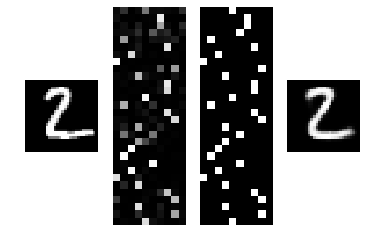

In [0]:
row = X_test[1]
x_encoded, code, x_decoded = test_enc_dec(row)
plot_test_mnist(row, x_encoded, code, x_decoded)

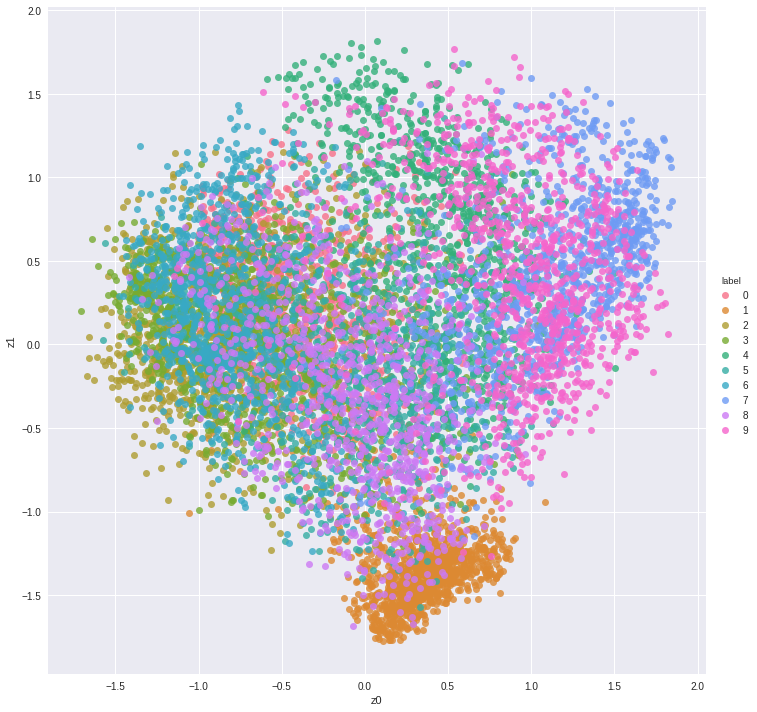

In [0]:
# Predict on test set
z_samples, _ = vae.encoder.predict(X_test)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(z_samples)
X = pca.transform(z_samples)

data = pd.DataFrame(X)
data.columns = ['z0', 'z1']
data['label'] = y_test
sns.lmplot(x="z0", y="z1", hue="label", data=data, fit_reg=False, size=10)

<a id='cnn-vae'></a>

## CNN VAE

In [0]:
class cnn_vae():
    def __init__(self, img_rows, img_cols, channels):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (img_rows, img_cols, channels)
        self.original_dim = img_rows * img_cols * channels
        self.latent_dim = 2
        
        # Build the encoder / decoder
        self.encoder, conv_shape = self.build_encoder()
        self.decoder = self.build_decoder(conv_shape)

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        z_mean, z_log_var, encoded_repr = self.encoder(img)
        img_reconst = self.decoder(encoded_repr)

        self.vae = Model(img, img_reconst)
        
        def vae_loss(inputs, outputs):
            # VAE loss = mse_loss or xent_loss + kl_loss
            if True:
                reconst_loss = self.original_dim * objectives.mse(K.flatten(inputs), K.flatten(outputs))
            else:
                reconst_loss = self.original_dim * objectives.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(reconst_loss + kl_loss)
        
        self.vae.compile(optimizer='adam', loss=vae_loss)


    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling from an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            latent_dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
        # Encoder
        inputs = Input(shape=self.img_shape)
        x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs)
        x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        
        # shape info needed to build decoder model
        conv_shape = K.int_shape(x)
        
        x = Flatten()(x)
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim, ))([z_mean, z_log_var])

        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z])
        print(encoder.summary())
        return encoder, conv_shape

    
    def build_decoder(self, conv_shape):
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim, ))
        x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(latent_inputs)
        x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        outputs = Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder


    def train(self, X_train, X_test, epochs, batch_size):
        file_path = 'weights.h5'
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                                     save_best_only=True, mode='min')
        early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
        
        self.vae.fit(X_train, X_train,
                     shuffle=True,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_test, X_test),
                     callbacks=[checkpoint, early])


In [0]:
img_rows = 28
img_cols = 28
channels = 1
epochs = 10
batch_size = 128

vae = cnn_vae(img_rows, img_cols, channels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 14, 14, 32)   320         input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_15[0][0]                  
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 3136)         0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dense_37 (

In [0]:
vae.train(X_train, X_test, epochs, batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 117s 2ms/step - loss: 54.7537 - val_loss: 45.1399

Epoch 00001: val_loss improved from 48.86189 to 45.13995, saving model to weights.h5
Epoch 2/10
60000/60000 [==============================] - 115s 2ms/step - loss: 43.6643 - val_loss: 42.4074

Epoch 00002: val_loss improved from 45.13995 to 42.40740, saving model to weights.h5
Epoch 3/10
60000/60000 [==============================] - 116s 2ms/step - loss: 41.5765 - val_loss: 40.9054

Epoch 00003: val_loss improved from 42.40740 to 40.90545, saving model to weights.h5
Epoch 4/10
60000/60000 [==============================] - 115s 2ms/step - loss: 40.5264 - val_loss: 40.3009

Epoch 00004: val_loss improved from 40.90545 to 40.30093, saving model to weights.h5
Epoch 5/10
60000/60000 [==============================] - 115s 2ms/step - loss: 39.9373 - val_loss: 39.6410

Epoch 00005: val_loss improved from 40.30093 to 39.64103, saving 

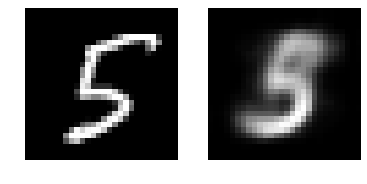

In [0]:
# test image
img = X_test[23].reshape(1, img_rows, img_cols, 1)
_, _, z_sample = vae.encoder.predict(img)
x_decoded = vae.decoder.predict(z_sample)

plt.figure()
plt.subplot(121)
plt.imshow(img.reshape(img_rows, img_cols), cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(x_decoded.reshape(img_rows, img_cols), cmap='gray')
plt.axis('off')
plt.show()

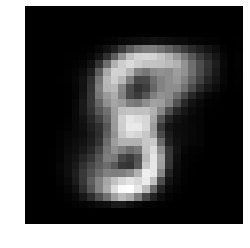

In [0]:
# random sample
z_sample = np.array([[0, 0.1]])
x_decoded = vae.decoder.predict(z_sample)

plt.figure()
plt.imshow(x_decoded.reshape(img_rows, img_cols), cmap='gray')
plt.axis('off')
plt.show()

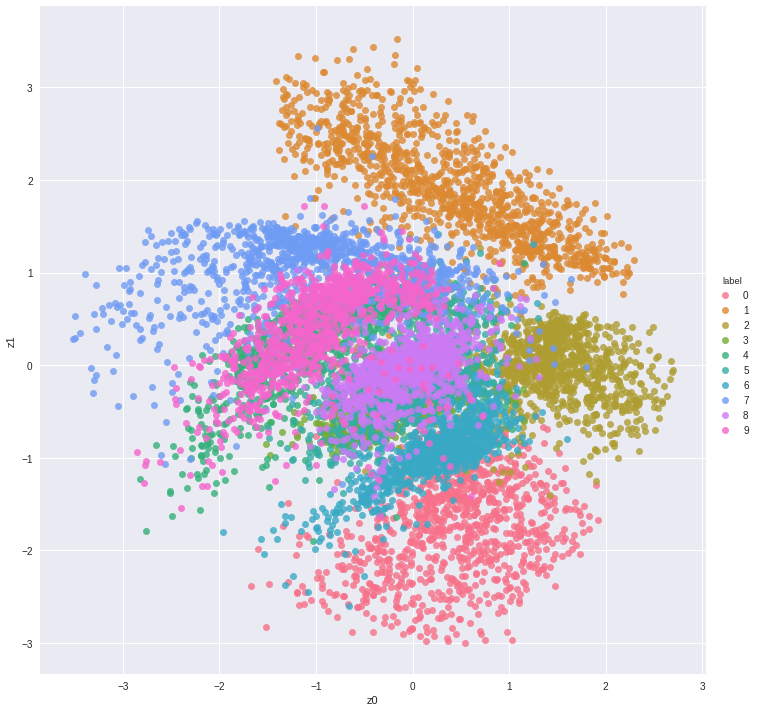

In [0]:
# Predict on test set
z_mean, _, _ = vae.encoder.predict(X_test)

data = pd.DataFrame(z_mean)
data.columns = ['z0', 'z1']
data['label'] = y_test
sns.lmplot(x="z0", y="z1", hue="label", data=data, fit_reg=False, size=10)

<a id='lstm-vae|'></a>

## LSTM VAE

In [0]:
class lstm_vae():
    def __init__(self, input_dim, timesteps):
        self.input_dim = input_dim
        self.timesteps = timesteps
        self.input_shape = (timesteps, input_dim)
        self.latent_dim = 2
        
        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.input_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        z_mean, z_log_var, encoded_repr = self.encoder(img)
        img_reconst = self.decoder(encoded_repr)

        self.vae = Model(img, img_reconst)
        
        def vae_loss(inputs, outputs):
            # VAE loss = mse_loss or xent_loss + kl_loss
            if True:
                reconst_loss = self.input_dim * objectives.mse(K.flatten(inputs), K.flatten(outputs))
            else:
                reconst_loss = self.input_dim * objectives.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
            return K.mean(reconst_loss + kl_loss)
        
        self.vae.compile(optimizer='adam', loss=vae_loss)


    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling from an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            latent_dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
        # Encoder
        inputs = Input(shape=self.input_shape)
        x = LSTM(256)(inputs)
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim, ))([z_mean, z_log_var])

        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z])
        print(encoder.summary())
        return encoder

    
    def build_decoder(self):
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim, ))
        x = RepeatVector(timesteps)(latent_inputs)
        x = LSTM(256, return_sequences=True)(x)
        outputs = LSTM(input_dim, return_sequences=True)(x)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder


    def train(self, X_train, X_test, epochs, batch_size):
        file_path = 'weights.h5'
        checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                                     save_best_only=True, mode='min')
        early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
        
        self.vae.fit(X_train, X_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(X_test, X_test),
                     callbacks=[checkpoint, early])


In [0]:
input_dim = 28
timesteps = 28
epochs = 10
batch_size = 1  # can only be 1

vae = lstm_vae(input_dim, timesteps)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          291840      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            514         lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_1 (

In [0]:
vae.train(X_train, X_test, epochs, batch_size)
# hopelessly slow

<a id='aae'></a>

## Adversarial AE

In [0]:
class adversarial_ae():
    def __init__(self, img_rows, img_cols, channels, latent_dim=2):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (img_rows, img_cols, channels)
        self.original_dim = img_rows * img_cols * channels
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.aae = Model(img, [reconstructed_img, validity])
        self.aae.compile(
            loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

        
    def build_encoder(self):
        def sampling(args):
            """Reparameterization trick by sampling from an isotropic unit Gaussian.
            # Arguments:
                args (tensor): mean and log of variance of Q(z|X)
            # Returns:
                z (tensor): sampled latent vector
            """
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            latent_dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
        # Encoder
        inputs = Input(shape=self.img_shape)
        h = Flatten()(inputs)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)
        
        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(self.latent_dim, ))([z_mean, z_log_var])
        
        # instantiate encoder model
        encoder = Model(inputs, z)
        print(encoder.summary())
        return encoder

    
    def build_decoder(self):
        # Decoder
        latent_inputs = Input(shape=(self.latent_dim, ))
        h = Dense(512)(latent_inputs)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(512)(h)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(self.original_dim, activation='tanh')(h)
        outputs = Reshape(self.img_shape)(h)
        
        # instantiate decoder model
        decoder = Model(latent_inputs, outputs)
        print(decoder.summary())
        return decoder

    
    def build_discriminator(self):
        # Discriminator
        latent_inputs = Input(shape=(self.latent_dim, ))
        h = Dense(512)(latent_inputs)
        h = LeakyReLU(alpha=0.2)(h)
        h = Dense(256)(h)
        h = LeakyReLU(alpha=0.2)(h)
        validity = Dense(1, activation='sigmoid')(h)
        
        # instantiate discriminator model
        discriminator = Model(latent_inputs, validity)
        print(discriminator.summary())
        return discriminator

    
    def train(self, dataset, epochs, batch_size,
              print_every=50, show_every=250):
#         # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()

#         # Rescale -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#         X_train = np.expand_dims(X_train, axis=3)

        

        it = 0
        for epoch in range(epochs):
            for minibatch in dataset.batches(batch_size):
                
                # Adversarial ground truths
                valid = np.ones((len(minibatch), 1))
                fake = np.zeros((len(minibatch), 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------

#                 # Select a random batch of images
#                 idx = np.random.randint(0, X_train.shape[0], batch_size)
#                 imgs = X_train[idx]

                latent_fake = self.encoder.predict(minibatch)
                latent_real = np.random.normal(size=(len(minibatch), self.latent_dim))

                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
                d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator
                g_loss = self.aae.train_on_batch(minibatch, [minibatch, valid])

                # Show progress
                if it % print_every == 0:
                    print("Epoch %d/%d, Iter %d: [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % 
                          (epoch+1, epochs, it, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
                
                if it % show_every == 0:
                    z = np.random.normal(size=(16, self.latent_dim))
                    gen_imgs = self.decoder.predict(z)
                    gen_imgs = 0.5 * gen_imgs + 0.5
                    show_images(gen_imgs)
                
                it += 1

In [0]:
img_rows = 28
img_cols = 28
channels = 1
epochs = 20
batch_size = 128

X_train_batches = dataset_batches(X_train)
aae = adversarial_ae(img_rows, img_cols, channels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               1536      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 257       
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________
None

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/5, Iter 0: [D loss: 0.622206, acc: 64.06%] [G loss: 0.160363, mse: 0.159277]


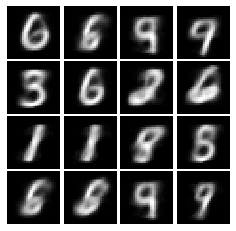

Epoch 1/5, Iter 50: [D loss: 0.599089, acc: 63.67%] [G loss: 0.153305, mse: 0.152208]
Epoch 1/5, Iter 100: [D loss: 0.608690, acc: 66.41%] [G loss: 0.172592, mse: 0.171328]
Epoch 1/5, Iter 150: [D loss: 0.577834, acc: 67.58%] [G loss: 0.161823, mse: 0.160285]
Epoch 1/5, Iter 200: [D loss: 0.579059, acc: 66.80%] [G loss: 0.159118, mse: 0.157876]
Epoch 1/5, Iter 250: [D loss: 0.637333, acc: 60.55%] [G loss: 0.162756, mse: 0.161547]


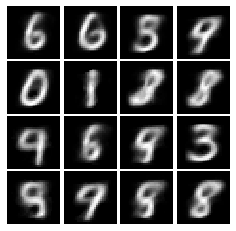

Epoch 1/5, Iter 300: [D loss: 0.604112, acc: 66.80%] [G loss: 0.153146, mse: 0.151843]
Epoch 1/5, Iter 350: [D loss: 0.600028, acc: 65.62%] [G loss: 0.160105, mse: 0.158967]
Epoch 1/5, Iter 400: [D loss: 0.626686, acc: 65.23%] [G loss: 0.170018, mse: 0.168914]
Epoch 1/5, Iter 450: [D loss: 0.552340, acc: 69.92%] [G loss: 0.163469, mse: 0.162172]
Epoch 2/5, Iter 500: [D loss: 0.575702, acc: 71.09%] [G loss: 0.156479, mse: 0.155027]


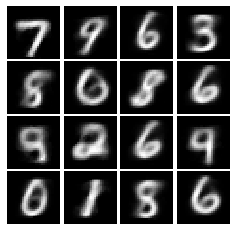

Epoch 2/5, Iter 550: [D loss: 0.592275, acc: 66.41%] [G loss: 0.161111, mse: 0.159798]
Epoch 2/5, Iter 600: [D loss: 0.590491, acc: 66.02%] [G loss: 0.168450, mse: 0.167160]
Epoch 2/5, Iter 650: [D loss: 0.588324, acc: 67.97%] [G loss: 0.161858, mse: 0.160594]
Epoch 2/5, Iter 700: [D loss: 0.569957, acc: 66.41%] [G loss: 0.150609, mse: 0.149170]
Epoch 2/5, Iter 750: [D loss: 0.605896, acc: 64.84%] [G loss: 0.174377, mse: 0.173191]


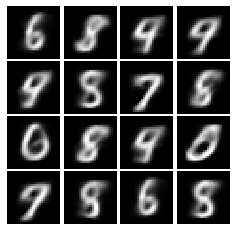

Epoch 2/5, Iter 800: [D loss: 0.637508, acc: 64.84%] [G loss: 0.160126, mse: 0.159097]
Epoch 2/5, Iter 850: [D loss: 0.608729, acc: 64.06%] [G loss: 0.161914, mse: 0.160890]
Epoch 2/5, Iter 900: [D loss: 0.569038, acc: 69.53%] [G loss: 0.159366, mse: 0.158119]
Epoch 3/5, Iter 950: [D loss: 0.598305, acc: 64.06%] [G loss: 0.154633, mse: 0.153472]
Epoch 3/5, Iter 1000: [D loss: 0.562418, acc: 69.92%] [G loss: 0.171958, mse: 0.170678]


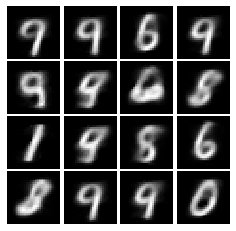

Epoch 3/5, Iter 1050: [D loss: 0.588262, acc: 67.19%] [G loss: 0.155355, mse: 0.154198]
Epoch 3/5, Iter 1100: [D loss: 0.554809, acc: 67.58%] [G loss: 0.147802, mse: 0.146399]
Epoch 3/5, Iter 1150: [D loss: 0.554915, acc: 71.48%] [G loss: 0.168595, mse: 0.167385]
Epoch 3/5, Iter 1200: [D loss: 0.571999, acc: 68.75%] [G loss: 0.153259, mse: 0.152039]
Epoch 3/5, Iter 1250: [D loss: 0.590784, acc: 66.41%] [G loss: 0.160186, mse: 0.158950]


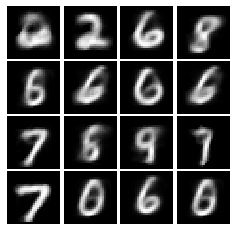

Epoch 3/5, Iter 1300: [D loss: 0.578928, acc: 66.80%] [G loss: 0.148508, mse: 0.147190]
Epoch 3/5, Iter 1350: [D loss: 0.640538, acc: 60.16%] [G loss: 0.171579, mse: 0.170736]
Epoch 3/5, Iter 1400: [D loss: 0.628760, acc: 66.41%] [G loss: 0.161864, mse: 0.160959]
Epoch 4/5, Iter 1450: [D loss: 0.592716, acc: 67.97%] [G loss: 0.165478, mse: 0.164268]
Epoch 4/5, Iter 1500: [D loss: 0.585993, acc: 66.41%] [G loss: 0.159870, mse: 0.158771]


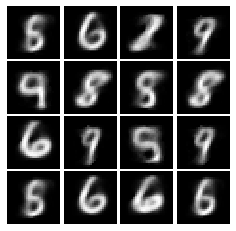

Epoch 4/5, Iter 1550: [D loss: 0.633105, acc: 62.89%] [G loss: 0.166133, mse: 0.165108]
Epoch 4/5, Iter 1600: [D loss: 0.638128, acc: 63.28%] [G loss: 0.156966, mse: 0.155802]
Epoch 4/5, Iter 1650: [D loss: 0.604063, acc: 67.58%] [G loss: 0.160457, mse: 0.159128]
Epoch 4/5, Iter 1700: [D loss: 0.598655, acc: 65.62%] [G loss: 0.151717, mse: 0.150550]
Epoch 4/5, Iter 1750: [D loss: 0.596237, acc: 67.97%] [G loss: 0.160270, mse: 0.159229]


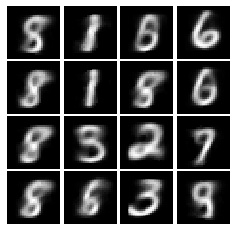

Epoch 4/5, Iter 1800: [D loss: 0.573189, acc: 69.14%] [G loss: 0.160600, mse: 0.159488]
Epoch 4/5, Iter 1850: [D loss: 0.635301, acc: 62.89%] [G loss: 0.160522, mse: 0.159511]
Epoch 5/5, Iter 1900: [D loss: 0.586555, acc: 67.19%] [G loss: 0.157454, mse: 0.156274]
Epoch 5/5, Iter 1950: [D loss: 0.615964, acc: 60.94%] [G loss: 0.156719, mse: 0.155719]
Epoch 5/5, Iter 2000: [D loss: 0.650791, acc: 60.94%] [G loss: 0.157130, mse: 0.156134]


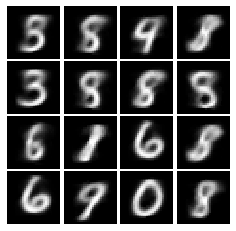

Epoch 5/5, Iter 2050: [D loss: 0.604607, acc: 64.06%] [G loss: 0.161600, mse: 0.160436]
Epoch 5/5, Iter 2100: [D loss: 0.577018, acc: 69.14%] [G loss: 0.152772, mse: 0.151589]
Epoch 5/5, Iter 2150: [D loss: 0.571548, acc: 70.70%] [G loss: 0.159226, mse: 0.158045]
Epoch 5/5, Iter 2200: [D loss: 0.612212, acc: 63.28%] [G loss: 0.155719, mse: 0.154504]
Epoch 5/5, Iter 2250: [D loss: 0.653566, acc: 60.94%] [G loss: 0.160120, mse: 0.159010]


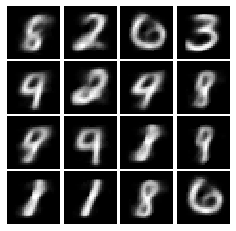

Epoch 5/5, Iter 2300: [D loss: 0.570853, acc: 67.97%] [G loss: 0.153433, mse: 0.152131]


In [0]:
aae.train(X_train_batches, epochs=5, batch_size=batch_size)